<a href="https://colab.research.google.com/github/divyanshu293/Apni-Dukaan/blob/main/Customer_invoice_delay_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'payment-date-prediction-for-invoices-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2921524%2F5033735%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240825%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240825T103026Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc5184956eebd38c1b9239f80df5d27de5f548d846f784e1382a7d6c4e2b0e41cf2f8939952a588f7e40a63805c224803598d765ad4aa0061f07fa607c82b1fc277054052f7635c01dfcdcaf114796e2f2496126a824d07270d72cb429ec77ed4bd55ad1737e5232aa0cbd1cc59517bcfbffad941ddfa45d94af20a95a18b4e73e3bf9df3f43f2875d0979c23976ce262ac812c0baf7a1d311f0b0b1c9dc239c6f54cf01a78ca5df786b362de0e2c188883512c0acdef9f44dc2abbbe00c18ac13628a8f9dbaaff49881141295d50c4b030282af2223d34d0fb4a98da6126f53ca81dc8a67a1da6cf2dae2ffdffb84ae0a7fb260b59ac2697ef64418099de13da'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1726180 bytes downloaded
Downloaded and uncompressed: payment-date-prediction-for-invoices-dataset
Data source import complete.


# Summary

In [4]:
!pip3 install catboost shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 23.3 MB/s eta 0:00:00


In [5]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
import shap

In [6]:
data = pd.read_csv('/kaggle/input/payment-date-prediction-for-invoices-dataset/dataset.csv')

In [16]:
data

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,invoice_id,isOpen,payment_delay_in_days,payment_term_in_days,biz_code_CA02,biz_code_U001,biz_code_U002,biz_code_U005,biz_code_U007,biz_code_U013
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,20200125,20200126,2020-02-10,...,1.930438e+09,0,1.0,15,False,True,False,False,False,False
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,20190722,20190722,2019-08-11,...,1.929646e+09,0,-3.0,20,False,True,False,False,False,False
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,20190914,20190914,2019-09-29,...,1.929874e+09,0,92.0,15,False,True,False,False,False,False
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,20200330,20200330,2020-04-10,...,2.960623e+09,1,0.0,10,True,False,False,False,False,False
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,20191113,20191113,2019-11-28,...,1.930148e+09,0,-3.0,15,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,U001,0200561861,CO corporation,NaT,2020.0,1.930797e+09,2020-04-21,20200417,20200421,2020-05-06,...,1.930797e+09,1,0.0,15,False,True,False,False,False,False
49996,U001,0200769623,WAL-MAR co,2019-09-03,2019.0,1.929744e+09,2019-08-15,20190814,20190815,2019-08-30,...,1.929744e+09,0,4.0,15,False,True,False,False,False,False
49997,U001,0200772595,SAFEW associates,2020-03-05,2020.0,1.930537e+09,2020-02-19,20200218,20200219,2020-03-05,...,1.930537e+09,0,0.0,15,False,True,False,False,False,False
49998,U001,0200726979,BJ'S llc,2019-12-12,2019.0,1.930199e+09,2019-11-27,20191126,20191127,2019-12-12,...,1.930199e+09,0,0.0,15,False,True,False,False,False,False


In [ ]:
data.info()

# Data cleaning and pre-processing

In [ ]:
# checkinig if there is any missing data

(data.isna().sum() / len(data)).sort_values(ascending=False)

In [9]:
# changing the data type for some columns, where needed

data['clear_date'] = pd.to_datetime(data['clear_date'], format='%Y-%m-%d %H:%M:%S')
data['due_in_date'] = pd.to_datetime(data['due_in_date'], format='%Y%m%d')
data['baseline_create_date'] = pd.to_datetime(data['baseline_create_date'], format='%Y%m%d')

In [ ]:
# checking if there are any duplicates in 'doc_id' column

data['doc_id'].value_counts()

In [10]:
# some document id's appear more than once, therefore I remove duplicates

data = data.drop_duplicates(subset=['doc_id'])

In [11]:
# adding column with pyment delay for each invoice
data['payment_delay_in_days'] = (data['clear_date'] - data['due_in_date']).dt.days

# adding column with payment term for each invoice
data['payment_term_in_days'] = (data['due_in_date'] - data['baseline_create_date']).dt.days

In [17]:
data['payment_delay_in_days']

,payment_delay_in_days
0,1.0
1,-3.0
2,92.0
3,0.0
4,-3.0
...,...
49995,0.0
49996,4.0
49997,0.0
49998,0.0


In [12]:
# splitting the 'business_code' column into separate dummy varialble columns

biz_code_cols = pd.get_dummies(data['business_code'], prefix='biz_code')
data[biz_code_cols.columns] = biz_code_cols

In [19]:
# calculating the mean delay for each customer
# data['payment_delay_in_days'] = pd.to_numeric(data['payment_delay_in_days'], errors='coerce')
# data['payment_delay_in_days'].fillna(0, inplace=True)  # or use another strategy for handling NaNs

avg_customer_delay = data.groupby(['name_customer'])['payment_delay_in_days'].mean()

# for customers with no prior invoices I use the average deay of all other customers
avg_customer_delay.fillna(avg_customer_delay.mean(), inplace=True)

avg_customer_delay.rename('avg_customer_delay', inplace=True)

# adding average customer deelay data to the main dataframe
data = pd.merge(data, avg_customer_delay, on='name_customer', how='left')

In [20]:
avg_customer_delay


,avg_customer_delay
name_customer,
11078 us,17.0
17135 associates,-10.0
17135 llc,-3.0
17135 trust,0.0
17135 us,0.0
...,...
YEN BROS corporation,-0.5
YEN BROS llc,-2.0
ZARCO co,-1.0


In [21]:
# checking for possible invoice currencies

data['invoice_currency'].value_counts()

,count
invoice_currency,
USD,45011
CAD,3828


In [22]:
# adding new column with all invoice amounts in USD (amounts in CAD are converted to USD assuming 0.75 fx rate)

data['usd_amount'] = data['total_open_amount'].where(data['invoice_currency'] == 'USD', data['total_open_amount']*0.75)

In [23]:
# creating dummy variable column for invoice currency

data['invoice_in_USD'] = pd.get_dummies(data['invoice_currency'])['USD']

In [24]:
# checking for possible doc types

data['document type'].value_counts()

,count
document type,
RV,48833
X2,6


In [25]:
# creating dummy variable column for document type

data['doc_type_RV'] = pd.get_dummies(data['document type'])['RV']

In [26]:
# there seems to be a pattern among customer numbers. some start with 'CC', some with '0', etc

data['cust_number'].str[:2].value_counts()

,count
cust_number,
02,38960
01,5581
20,2552
CC,1394
14,219
10,133


In [27]:
# therefore I create separate dummy columns based on the first two characters in customer number

data['customer_category'] = data['cust_number'].str[:2]

cust_categories = pd.get_dummies(data['customer_category'], prefix='cust_category')
data[cust_categories.columns] = cust_categories

# Exploratory analysis

In [28]:
# separating closed invoices from the ones that are still open, in two different datasets

closed_invoices = data[~data['clear_date'].isna()]
open_invoices = data[data['clear_date'].isna()]

In [29]:
# adding a column that shows whether the invoice was delayed by more than 7 days or not

closed_invoices['is_overdue'] = closed_invoices['payment_delay_in_days'] > 7
closed_invoices['is_overdue'] = closed_invoices['is_overdue'].apply(lambda x:1 if x == True else 0)

<ipython-input-29-b03f8acffae4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_invoices['is_overdue'] = closed_invoices['payment_delay_in_days'] > 7
<ipython-input-29-b03f8acffae4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_invoices['is_overdue'] = closed_invoices['is_overdue'].apply(lambda x:1 if x == True else 0)


In [30]:
# defining a function that will return summary of invoice delays, depending on inputted column name

def overdue_summary(column_name):

    grp = closed_invoices.groupby(column_name).agg(
        invoice_count = ('doc_id', 'count'),
        overdue_share = ('is_overdue', 'mean')
    ).sort_values('invoice_count', ascending=False)

    return grp.style.bar(subset=['invoice_count'], color='#B1DFB4').bar(subset=['overdue_share'], color='#B1DFE8').format({'overdue_share': '{:.1%}'})

In [31]:
# out of all closed invoices, 6.7% were delayed by more than 7 days
# the average payment delay is 0.84 days

closed_invoices[['payment_delay_in_days', 'is_overdue']].mean()

,0
payment_delay_in_days,0.837147
is_overdue,0.067343


In [32]:
# invoices with 'business_code' other than 'U001', have noticeably more delays

overdue_summary('business_code')

,invoice_count,overdue_share
business_code,,
U001,35417,5.1%
CA02,3122,21.0%
U013,492,31.5%
U002,115,19.1%
U005,9,66.7%
U007,3,33.3%


In [33]:
# customers whose 'cust_number' starts with 'CC' have significantly more frequent delays

overdue_summary('customer_category')

,invoice_count,overdue_share
customer_category,,
02,31075,2.7%
01,4600,17.1%
20,1969,2.5%
CC,1265,72.1%
14,155,29.7%
10,94,14.9%


In [34]:
# invoices in CAD currency are more likely to be delayed

overdue_summary('invoice_currency')

,invoice_count,overdue_share
invoice_currency,,
USD,36034,5.5%
CAD,3124,21.0%


In [35]:
# 'X2' type invoices have all been delayed, however there are only 6 invoices with such type

overdue_summary('document type')

,invoice_count,overdue_share
document type,,
RV,39152,6.7%
X2,6,100.0%


In [36]:
# invoices with shorter payment terms tend to have more delays


closed_invoices['paym_term_categ'] = pd.cut(closed_invoices['payment_term_in_days'], 10)

closed_invoices.groupby('paym_term_categ').agg(
        invoice_count = ('doc_id', 'count'),
        overdue_share = ('is_overdue', 'mean'),
        avg_overdue_days = ('payment_delay_in_days', 'mean')
    ).style.bar(subset=['invoice_count'], color='#B1DFB4').bar(subset=['overdue_share'], color='#B1DFE8').bar(subset=['avg_overdue_days'], color='#B1DFB4').bar(subset=['avg_overdue_days'], color='#ECC4C4').format({'overdue_share': '{:.1%}', 'avg_overdue_days':'{:.1f}'})


<ipython-input-36-8a1ef1ea6d5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_invoices['paym_term_categ'] = pd.cut(closed_invoices['payment_term_in_days'], 10)
<ipython-input-36-8a1ef1ea6d5e>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  closed_invoices.groupby('paym_term_categ').agg(


,invoice_count,overdue_share,avg_overdue_days
paym_term_categ,,,
"(-0.12, 12.0]",4699,26.2%,9.4
"(12.0, 24.0]",30899,2.4%,-0.2
"(24.0, 36.0]",2082,22.0%,0.6
"(36.0, 48.0]",426,27.9%,6.2
"(48.0, 60.0]",184,32.1%,2.6
"(60.0, 72.0]",639,1.6%,-14.5
"(72.0, 84.0]",92,8.7%,-2.9
"(84.0, 96.0]",119,7.6%,-7.7
"(96.0, 108.0]",1,0.0%,-56.0


In [37]:
# invoices for the amount of USD 2,829 - USD 24,744 seem to have more delays than invoices for other amounts


closed_invoices['usd_amount_category'] = pd.qcut(closed_invoices['usd_amount'], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

closed_invoices.groupby('usd_amount_category').agg(
        invoice_count = ('doc_id', 'count'),
        overdue_share = ('is_overdue', 'mean'),
        avg_overdue_days = ('payment_delay_in_days', 'mean')
    ).style.bar(subset=['invoice_count'], color='#B1DFB4').bar(subset=['overdue_share'], color='#B1DFE8').bar(subset=['avg_overdue_days'], color='#B1DFB4').bar(subset=['avg_overdue_days'], color='#ECC4C4').format({'overdue_share': '{:.1%}', 'avg_overdue_days':'{:.1f}'})

<ipython-input-37-0c6f0baf7ca4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_invoices['usd_amount_category'] = pd.qcut(closed_invoices['usd_amount'], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
<ipython-input-37-0c6f0baf7ca4>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  closed_invoices.groupby('usd_amount_category').agg(


,invoice_count,overdue_share,avg_overdue_days
usd_amount_category,,,
"(0.789, 805.026]",3916,5.9%,0.6
"(805.026, 2829.374]",3916,6.5%,0.1
"(2829.374, 6788.868]",3916,7.9%,0.6
"(6788.868, 12548.982]",3915,9.8%,1.9
"(12548.982, 16958.85]",3916,8.5%,1.2
"(16958.85, 24744.606]",3916,8.4%,1.9
"(24744.606, 38478.199]",3915,5.9%,0.9
"(38478.199, 53497.444]",3916,5.0%,-0.1
"(53497.444, 79453.589]",3916,4.9%,0.1


# ML algorithm's prediction of invoice delays

### preprocessing and model training

In [38]:
# defining the columns that will be used to train the algorithm

input_columns = [
    'payment_term_in_days',
    'biz_code_CA02',
    'biz_code_U001',
    'biz_code_U002',
    'biz_code_U005',
    'biz_code_U007',
    'biz_code_U013',
    'usd_amount',
    'invoice_in_USD',
    'doc_type_RV',
    'cust_category_01',
    'cust_category_02',
    'cust_category_10',
    'cust_category_14',
    'cust_category_20',
    'cust_category_CC'
]

In [39]:
# defining the input variables and the column to predict
X = closed_invoices[input_columns].values
y = closed_invoices['is_overdue'].values


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# training the model
classifier = CatBoostClassifier(silent=True)
classifier.fit(X_train, y_train)

# ML algorithm's prediction results

In [40]:
# Making the Confusion Matrix and reading the accuracy of predictions

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
accuracy_score(y_test, y_pred)

[[7275   34]
 [ 378  145]]


0.9473953013278856

In [41]:
# Applying k-Fold Cross Validation

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 94.84 %
Standard Deviation: 0.28 %


In [42]:
# determining feature importances on the model outcome

feature_importance = pd.DataFrame()
feature_importance['feature'] = closed_invoices[input_columns].columns
feature_importance['importance'] = classifier.feature_importances_

feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

feature_importance

,importance
feature,
cust_category_CC,34.408306
payment_term_in_days,27.167210
usd_amount,22.280582
invoice_in_USD,4.102649
cust_category_02,3.944062
cust_category_01,2.498973
biz_code_U001,2.386683
cust_category_20,1.475995
biz_code_U013,0.483146


from matplotlib import pyplot as plt
_df_0['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: xlabel='feature'>

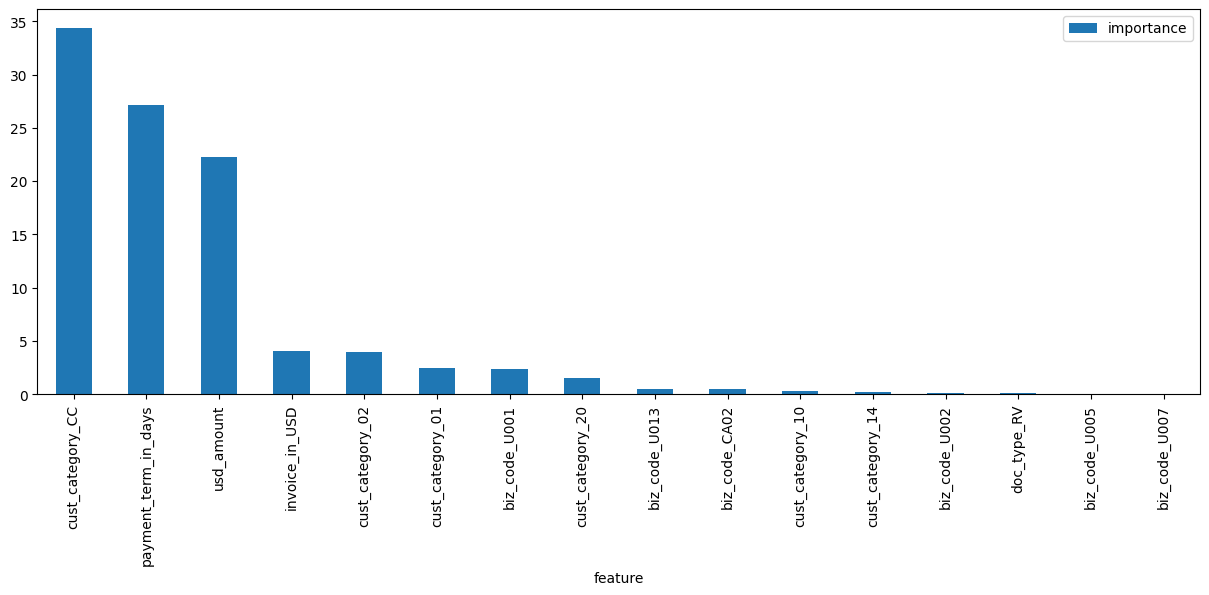

In [43]:
# whether the customer number starts with 'CC' seems to be the strongest predictor of whether the invoice will be delayed by 7 or more days
# payment term and invoice amount also affect the outcome a lot

feature_importance.plot(kind='bar', figsize=(15,5))

# Making predictions for invoices that are still open

In [44]:
# taking the input values from open_invoices data
pred_2 = open_invoices[input_columns].values

# feature scaling according to previosuly trained model
pred_2 = sc.transform(pred_2)

# making predictions whether any of the currently open invoices will be overdue or not
# and adding the predictions in new column 'is_overdue_pred'
open_invoices['is_overdue_pred'] = classifier.predict(pred_2)

<ipython-input-44-75ebec00e170>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_invoices['is_overdue_pred'] = classifier.predict(pred_2)


In [45]:
open_invoices

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,invoice_in_USD,doc_type_RV,customer_category,cust_category_01,cust_category_02,cust_category_10,cust_category_14,cust_category_20,cust_category_CC,is_overdue_pred
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,20200330,20200330,2020-04-10,...,False,True,01,True,False,False,False,False,False,0
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,20200318,20200319,2020-04-03,...,True,True,02,False,True,False,False,False,False,0
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,20200306,20200311,2020-03-26,...,True,True,02,False,True,False,False,False,False,0
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,20200415,20200415,2020-04-30,...,True,True,02,False,True,False,False,False,False,0
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,20200423,20200423,2020-04-26,...,True,True,02,False,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48817,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,20200309,20200310,2020-03-25,...,True,True,02,False,True,False,False,False,False,0
48822,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,20200502,20200503,2020-05-18,...,True,True,02,False,True,False,False,False,False,0
48824,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,20200311,20200311,2020-03-26,...,True,True,02,False,True,False,False,False,False,0
48831,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,20200325,20200325,2020-04-09,...,True,True,02,False,True,False,False,False,False,0


In [46]:
# there are 110 open invoices that will potentially get delayed by more than 7 days

print(open_invoices['is_overdue_pred'].sum())
print(open_invoices['is_overdue_pred'].mean())

110
0.011362462555521124
